##  Simple MultiAI agent Architecture 

In [1]:
from typing import List, Annotated
from typing_extensions import TypedDict
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_groq import ChatGroq
from pydantic import SecretStr
from IPython.display import Image, display
from langchain_tavily import TavilySearch
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver # memory for llm 
from langgraph.types import Command, interrupt
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
from IPython.display import Image, display
from langgraph.graph import StateGraph, END, MessagesState
from langchain_core.messages import SystemMessage



# load env
import os
load_dotenv()



True

In [2]:
os.environ["LANGSMITH_TRACING"]="true"

# set keys

langsmit_key = os.getenv("LANGSMITH_API_KEY")
if langsmit_key is None:
    raise EnvironmentError("LANGSMITH_API_KEY is not set in the environment.")
os.environ["LANGSMITH_API_KEY"] = langsmit_key

groq_key = os.getenv("GROQ_API_KEY")
if groq_key is None or langsmit_key is None:
    raise EnvironmentError("GROQ_API_KEY is not set in the environment.")
os.environ["GROQ_API_KEY"] = groq_key


# setup endpoint
os.environ["LANGSMITH_TRACING"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "Simple_multi_agent"

# LANGSMITH_PROJECT="pr-warmhearted-fiesta-95"
# OPENAI_API_KEY="<your-openai-api-key>"

In [3]:
#define state
class AgentState(MessagesState):
    next_agent:str #decide which agent should go next
    

In [4]:
#visualize graph
from IPython.display import Image, display
def display_graph(graph):
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(e)
        

In [17]:

def message_builder(role, message):
    return {"messages": [{"role": role, "content": message}]}

def invoke_message(graph, message, role="user", config=None):
    item=message_builder(role, message)
    if not config:
        return graph.invoke(item)
    return graph.invoke(item, config)

def pretty_print(response):
    for message in response['messages']:
        message.pretty_print()

In [6]:
# Create simple tools

@tool
def search_web(query:str) -> str:
    """ Search the web for information. """
    #using Tavily Search 
    search = TavilySearchResults(max_results=3)
    results = search.invoke(query=query)
    return str(results)

@tool
def write_summary(content:str) -> str:
    """ Write a summary of provided coontent. """
    # Simple summary generation 
    summary = f"Summary of findings : \n\n {content[:500]}"
    return summary

tools = [search_web, write_summary]

In [7]:
llm = ChatGroq(
    model="llama3-8b-8192",
    api_key=SecretStr(os.environ["GROQ_API_KEY"])
)

In [8]:
# Define agent function (simpler approach)
def researcher_agent(state:AgentState):
    """ Researcher agent that search for informations """
    
    message = state["messages"]
    
    # Add system message for context
    system_msg = SystemMessage(content="You are a researcher assistant. Use the search_web tool to find details about the query given ")
    
    #cakk LLM with tools
    tools = [search_web]
    researcher_llm = llm.bind_tools(tools)
    research_response = researcher_llm.invoke([system_msg] + message)
    
    #Return the response and route it to writer
    return {
        "messages":[research_response],
        "next_agent":"writer"
    } 

In [9]:
# Define agent function (simpler approach)
def writer_agent(state:AgentState):
    """ Writer agent that summarize theinformations """
    
    message = state["messages"]
    
    # Add system message for context
    system_msg = SystemMessage(content="You are a technical writer. Revie the conversation and create a consise summary out it.")
    
    # Simple completion without tools
    writer_response = llm.invoke([system_msg]+message)
    

    
    #Return the response and route it to writer
    return {
        "messages":[writer_response],
        "next_agent":"ned"
    } 

In [10]:
# Tool executor node
def execute_tools(state: AgentState):
    """ Execute any pending tools calls"""
    messages = state["messages"]
    last_message = messages[-1]
    
    #check if there are tool calls to execute
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        #create tool node and execute
        tool_node = ToolNode(tools)
        response = tool_node.invoke(state)
        return response
    
    # No tools to execute
    return state

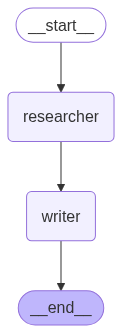

In [11]:
#  Multi agent graph
workflow = StateGraph(MessagesState)

# Add nodes
workflow.add_node("researcher", researcher_agent)
workflow.add_node("writer", writer_agent)

# Define flow
workflow.set_entry_point("researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", END)
final_workflow = workflow.compile()

display_graph(final_workflow)



In [28]:
response = invoke_message(graph=final_workflow, message="Research about the usecase about the agentic ai in business", role="user")
response["messages"][-1].content

' \n\nI\'ve conducted a thorough research on the topic of "Agentic AI in Business". After analyzing various articles, blogs, and research papers, I\'ve summarized the key findings below:\n\n**Definition of Agentic AI:**\nAgentic AI refers to artificial intelligence systems that possess the ability to act on their own behalf, making decisions and taking actions that align with their goals and objectives. This type of AI is often referred to as "intelligent agents" or " autonomous agents".\n\n**Benefits of Agentic AI in Business:**\nThe use of agentic AI in business can bring numerous benefits, including:\n\n1. **Increased Efficiency:** Agentic AI can automate routine tasks, freeing up human resources for more strategic and creative work.\n2. **Improved Decision-Making:** Agentic AI can analyze large amounts of data, identify patterns, and make recommendations, allowing businesses to make more informed decisions.\n3. **Enhanced Customer Experience:** Agentic AI can analyze customer behav